
# 2. Price Prediction
## 2.1 Data cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
import keras

import tensorflow as tf
import sklearn

from keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

tf.random.set_seed(0)

In [2]:
# Load
stock = pd.read_csv('./data/BYND.csv')
google_orig = pd.read_csv('./data/multiTimeline.csv', header=1)
covid = pd.read_csv('./data/national-history.csv')

# Convert all date column to date type
stock['Date'] = pd.to_datetime(stock['Date'])
covid['date'] = pd.to_datetime(covid['date'])
google_orig['Week'] = pd.to_datetime(google_orig['Week'])

stock = stock[['Date', 'Close']]

### 2.1.1 Clean Google Trend

In [12]:
# Available google trend data to market is lagged. For example, for this week, I can only see past week trend.
google = pd.DataFrame(columns=['date', 'search'])
for i, row in enumerate(google_orig.iterrows()):
    t = row[1]['Week']
    
    # today (t) trend score is only visible & used for t+1 to t+7
    for offset in range(1, 8):
        newrow = {'date': t + pd.DateOffset(offset),
                  'search': row[1]['beyond meat: (United States)']}
        google = google.append(newrow, ignore_index=True)
google

,date,search
0,2019-01-07,9
1,2019-01-08,9
2,2019-01-09,9
3,2019-01-10,9
4,2019-01-11,9
...,...,...
702,2020-12-09,11
703,2020-12-10,11
704,2020-12-11,11
705,2020-12-12,11


In [13]:
# Merge with stock price
stock['search'] = 0
for i, row in enumerate(stock.iterrows()):
    try:
        stock.loc[i, 'search'] = google.loc[google['date'] == row[1]['Date'], 'search'].values[0]
    except:
        # if no available search index, use the most recent one
        stock.loc[i, 'search'] = google['search'][len(google)-1]

### 2.1.2 Clean Financial statistics

In [15]:
stats = pd.read_csv('./data/financial_statistics.csv')
stats = stats.rename(columns={'Unnamed: 0': 'index'})
stats = stats.set_index('index').T
stats = stats[::-1]
stats.reset_index(inplace=True)
stats = stats.rename(columns={'index': 'Date'})
stats['Date'] = pd.to_datetime(stats['Date'])

In [16]:
stats['Revenue (M)'] = stats['Enterprise Value (B)']*1000 / stats['Enterprise Value/Revenue'] 
stats['EBITDA'] = stats['Enterprise Value (B)']*1000 / stats['Enterprise Value/EBITDA'] 
stat_keys = list(stats.columns[1:])
stat_keys.remove('Trailing P/E')
stat_keys.remove('PEG Ratio (5 yr expected)')
stat_keys

['Market Cap (intraday) (B)',
 'Enterprise Value (B)',
 'Forward P/E',
 'Price/Sales\xa0(ttm)',
 'Price/Book\xa0(mrq)',
 'Enterprise Value/Revenue',
 'Enterprise Value/EBITDA',
 'Revenue (M)',
 'EBITDA']

Assume that for each trading date, the available statistics is from the most recent published (previous)quater. For example, 2020-05-01 will only see stats from 2020-03-31.

In [17]:
for key in stat_keys:
    stock[key] = 0

stat_idx = 0
prev_stat_date = stats['Date'][stat_idx]
next_stat_date = stats['Date'][stat_idx + 1]
stat_row = stats[stats['Date'] == prev_stat_date]

for i, row in enumerate(stock.iterrows()):
    # if stock date greater than next stats' date and it is not the last row of stat.
    if row[1]['Date'] > next_stat_date and stat_idx != len(stats) - 1:
        stat_idx += 1
        prev_stat_date = stats['Date'][stat_idx]
        try:
            next_stat_date = stats['Date'][stat_idx +1]
        except:
            next_stat_date = pd.to_datetime('2020-12-30')
            
        stat_row = stats[stats['Date'] == prev_stat_date]

    for key in stat_keys:
        stock.loc[i, key] = stat_row[key].values[0]

### 2.1.3 Clean COVID

In [18]:
# Merge with stock price
# Lag for one day. Market can only see covid statistics for yesterday.
stock['COVID positiveIncrease'] = 0
stock['COVID deathIncrease'] = 0
for i, row in enumerate(stock.iterrows()):
    try:
        stock.loc[i, 'COVID positiveIncrease'] = covid.loc[covid['date'] == row[1]['Date'] - pd.DateOffset(1), 'positiveIncrease'].values[0]
        stock.loc[i, 'COVID deathIncrease'] = covid.loc[covid['date'] == row[1]['Date'] - pd.DateOffset(1), 'deathIncrease'].values[0]
    except:
        stock.loc[i, 'COVID positiveIncrease'] = 0
        stock.loc[i, 'COVID deathIncrease'] = 0

## 2.2 Preprocessing
### 2.2.1 Normalize

In [19]:
df0 = stock.copy()
normalize_dict = {}
# Normalize to 0 to 1
for col in df0.columns[1:]:
    _max = df0[col].max()
    _min = df0[col].min()
    normalize_dict[col] = [_min, _max]
    df0.loc[:, col] = (df0[col] - _min) / (_max - _min)

In [20]:
def reverse_scaler(series, col):
    _min, _max = normalize_dict[col]
    series = series * (_max - _min) + _min
    return series

### 2.2.2 Correlation and Features selection

In [137]:
# Check Correlation
corr = df0[df0.Date < stock.Date.max()].corr()['Close'].sort_values()
print(corr.sort_values())

# Keep the ones with significant correlation
corr = corr[corr.abs() > 0.1] 
df0 = df0.loc[:, ['Date'] + list(corr.index)]

non_lag_cols = list(df0.columns)
non_lag_cols.remove('Date')
non_lag_cols.remove('Close')
non_lag_cols.remove('COVID deathIncrease')
non_lag_cols.remove('Revenue (M)')

EBITDA                      -0.634448
Enterprise Value/EBITDA     -0.615820
search                      -0.182869
COVID deathIncrease          0.158313
Revenue (M)                  0.172708
COVID positiveIncrease       0.407277
Price/Book (mrq)             0.411584
Enterprise Value/Revenue     0.452705
Market Cap (intraday) (B)    0.483853
Enterprise Value (B)         0.487873
Close                        1.000000
Name: Close, dtype: float64


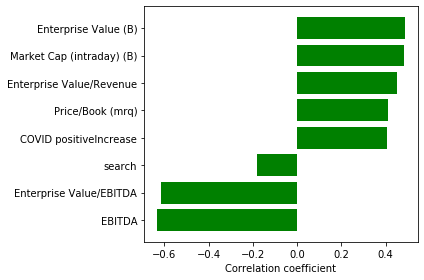

In [134]:
keys = list(corr.keys())
keys = [k for k in keys if k not in ['COVID deathIncrease', 'Revenue (M)', 'Close']]
plt.figure(figsize=(6,4))
corrs = [corr[k] for k in keys]
plt.barh(np.arange(len(keys)), corrs, color='green')
_ = plt.yticks( np.arange(len(keys)), keys)
_ = plt.xlabel('Correlation coefficient')
plt.tight_layout()
plt.savefig('./images/corr.png')

### 2.2.3 Add test dates into table

In [44]:
num_test_dates = 30
test_date0 = df0.Date.max()
print(test_date0)

2020-12-11 00:00:00


In [45]:
# covid new positive case
# during test period, assume that it has same number as the same week day in the last available week. 
last_week_covid = {}
_min, _max = normalize_dict['COVID positiveIncrease']
for i in range(1, 8):
    date = test_date0 - pd.DateOffset(i)
    cases = covid[covid['date'] == date]['positiveIncrease'].values[0]
    last_week_covid[date.dayofweek] = (cases - _min) / (_max - _min)
print(last_week_covid) 

{3: 1.0, 2: 0.9784438190004127, 1: 0.9984513305111073, 0: 0.8356277443675262, 6: 0.824467123230506, 5: 0.9873463501940474, 4: 1.0426996925844698}


In [56]:
last_row = df0.loc[len(df0)-1]

for dateOffset in range(0, num_test_dates + 1):
    new_row = last_row.copy()
    new_row['Date'] = test_date0 + pd.DateOffset(dateOffset)
    if new_row['Date'].dayofweek <= 4: # weekend are not trade date
        new_row[['Close','search']] = None
        new_row['COVID positiveIncrease'] = last_week_covid[new_row['Date'].dayofweek]
        df0 = df0.append(new_row, ignore_index=True)

### 2.2.4 Add lag data
since using lag data for predicting covid is extremely inaccurate, thus, only apply to stock price and search.

In [66]:
max_lag = 60
df1 = df0.copy()

for var in ['Close', 'search']:
    lag_t = df0[var].copy()
    for t in range(1, max_lag+1):
        for t_i in range(t):
            lag_t[t_i] = 0
        lag_t[t:] = df0[var][:len(lag_t)-t]
        df1[f'{var}_{t}'] = lag_t

df1 = df1.loc[max_lag+1:]
lag_cols = [f'Close_{t}' for t in range(1, max_lag+1)]
#covid_lag_cols = [f'COVID positiveIncrease_{t}' for t in range(1, max_lag+1)]
search_lag_cols = [f'search_{t}' for t in range(1, max_lag+1)]
non_lag_cols = [c for c in df1.columns if 'Close' not in c and 'search' not in c and 'Date' not in c]
non_lag_cols

print(df1.Date.min())

2020-03-11 00:00:00


In [48]:
df = df1.copy()
valid_date0 = pd.to_datetime('2020-10-15')

train = df[df['Date'] < valid_date0].reset_index(drop=True)
train_final = df[df['Date'] < test_date0].reset_index(drop=True)
valid = df[(valid_date0 <= df['Date']) & ( df['Date'] < test_date0)].reset_index(drop=True)
test = df[df['Date'] >= test_date0].reset_index(drop=True)

In [49]:
train_final.columns

Index(['Date', 'EBITDA', 'Enterprise Value/EBITDA', 'search',
       'COVID deathIncrease', 'Revenue (M)', 'COVID positiveIncrease',
       'Price/Book (mrq)', 'Enterprise Value/Revenue',
       'Market Cap (intraday) (B)',
       ...
       'search_51', 'search_52', 'search_53', 'search_54', 'search_55',
       'search_56', 'search_57', 'search_58', 'search_59', 'search_60'],
      dtype='object', length=132)

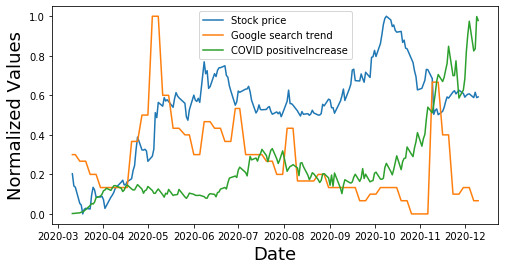

In [50]:
plt.figure(figsize=(8,4))
plt.plot(train_final['Date'], train_final['Close'], label='Stock price')
plt.plot(train_final['Date'], train_final['search'], label='Google search trend')
plt.plot(train_final['Date'], train_final['COVID positiveIncrease'], label='COVID positiveIncrease')
_ = plt.legend()
plt.xlabel('Date', fontsize=18)
plt.ylabel('Normalized Values', fontsize=18)
plt.savefig('./images/stock_normalized_plots.png')

## 2.3 Train LSTM 
### 2.3.1 with only lag data

In [67]:
def train_lstm(x_cols, y_col, data, epochs=2, batch_size=1):
    x_train = data[x_cols]
    y_train = np.array(data[y_col])
    x_train = np.expand_dims(np.array(x_train), -1)

    #Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences= False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    #Train the model
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
    return model

def test_lstm(model, x_lag_cols, y_col, data, with_gt=True):
    predictions = []
    x_valid = np.array(data[x_lag_cols])

    # for each new prediction, replace the lag data for future x
    for i in range(len(x_valid)):
        pred = model.predict(np.expand_dims(x_valid[i], (0,-1)))[0]
        for j in range(1, max_lag):
            if i + j < x_valid.shape[0]:
                x_valid[i+j][-j] = pred
        predictions.append(reverse_scaler(pred, y_col))
    #print(x_valid)
    
    # Get the root mean squared error (RMSE)
    if with_gt:
        rmse = np.sqrt(np.mean(((predictions - reverse_scaler(np.array(data[y_col]), y_col)) ** 2)))
        print(f'rmse for prediction {y_col} = {rmse:.3f}')
    return predictions

In [68]:
def plot_with_last_row(last_row, label, dates, pred, y_col, color='blue'):
    dates = pd.Series([last_row['Date']] + list(dates))
    preds = np.append(reverse_scaler(np.array([last_row[y_col]]), y_col),
                      np.ndarray.flatten(np.array(pred)))
    plt.plot(dates, preds, label=label, color=color)

In [69]:
batch_size, epochs = 7, 2
x_cols, y_col = search_lag_cols[::-1], 'search'

model = train_lstm(x_cols, y_col, data=train, batch_size=batch_size, epochs=epochs)
valid_pred_search = test_lstm(model, x_cols, y_col, data=valid)

model = train_lstm(x_cols, y_col, data=train_final, batch_size=batch_size, epochs=epochs)
test_pred_search = test_lstm(model, x_cols, y_col, data=test, with_gt=False)

Epoch 1/2
22/22 [==============================] - 1s 25ms/step - loss: 0.0410
Epoch 2/2
22/22 [==============================] - 1s 29ms/step - loss: 0.0227
rmse for prediction search = 7.053
Epoch 1/2
28/28 [==============================] - 1s 25ms/step - loss: 0.0437
Epoch 2/2
28/28 [==============================] - 1s 23ms/step - loss: 0.0271


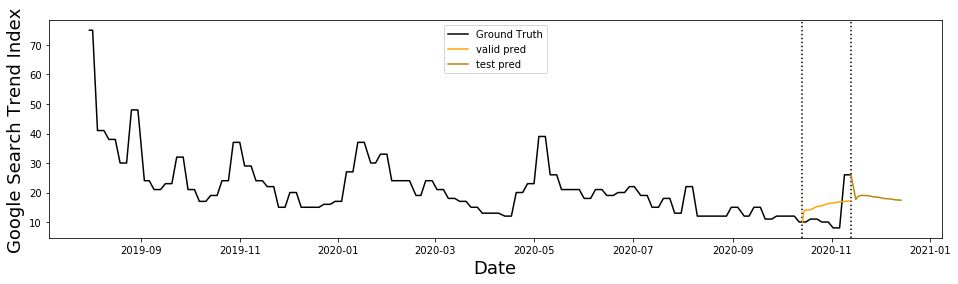

In [24]:
# Put test pred into test table
for i, date in enumerate(test['Date']):
    test.loc[test['Date'] == date, 'search'] = test_pred_search[i]
    
plt.figure(figsize=(16,4))

plt.xlabel('Date', fontsize=18)
plt.ylabel('Google Search Trend Index', fontsize=18)
plt.plot(train_final['Date'], reverse_scaler(train_final[y_col], y_col), label='Ground Truth', c='black')
plt.axvline(x=valid_date0-pd.DateOffset(1), ls=':', c='black')
plt.axvline(x=test_date0-pd.DateOffset(1), ls=':', c='black')

plot_with_last_row(last_row=train.loc[len(train)-1], label='valid pred', dates=valid['Date'], pred=valid_pred_search, y_col=y_col, color = 'orange')
plot_with_last_row(last_row=train_final.loc[len(train_final)-1], label='test pred', dates=test['Date'], pred=test_pred_search, y_col=y_col, color='darkgoldenrod')

plt.legend(loc='best')
plt.savefig('./images/search_results.png')
plt.show()

In [71]:
batch_size, epochs = 7, 2
x_cols, y_col = lag_cols[::-1], 'Close'

model = train_lstm(x_cols, y_col, data=train, batch_size=batch_size, epochs=epochs)
valid_pred = test_lstm(model, x_cols, y_col, data=valid)

model = train_lstm(x_cols, y_col, data=train_final, batch_size=batch_size, epochs=epochs)
test_pred = test_lstm(model, x_cols, y_col, data=test, with_gt=False)

Epoch 1/2
22/22 [==============================] - 1s 29ms/step - loss: 0.0514
Epoch 2/2
22/22 [==============================] - 1s 27ms/step - loss: 0.0135
rmse for prediction Close = 21.481
Epoch 1/2
28/28 [==============================] - 1s 24ms/step - loss: 0.0414
Epoch 2/2
28/28 [==============================] - 1s 24ms/step - loss: 0.0116


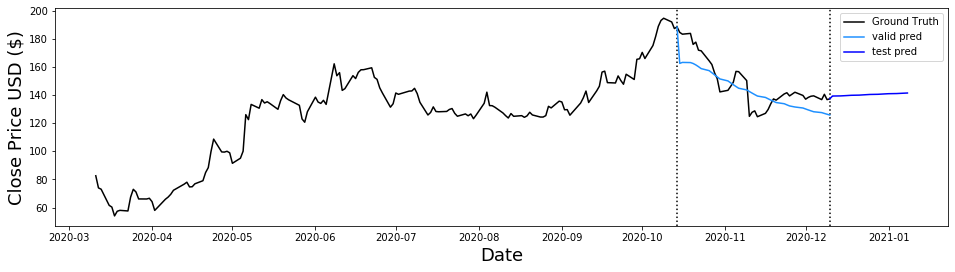

In [72]:
plt.figure(figsize=(16,4))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_final['Date'], reverse_scaler(train_final[y_col], y_col), label='Ground Truth', c='black')
plt.axvline(x=valid_date0-pd.DateOffset(1), ls=':', c='black')
plt.axvline(x=test_date0-pd.DateOffset(1), ls=':', c='black')

plot_with_last_row(last_row=train.loc[len(train)-1], label='valid pred', dates=valid['Date'], pred=valid_pred, y_col=y_col, color='dodgerblue')
plot_with_last_row(last_row=train_final.loc[len(train_final)-1], label='test pred', dates=test['Date'], pred=test_pred, y_col=y_col)

plt.legend(loc='best')
plt.savefig('./images/stock_results_lstm.png')
plt.show()
keras.backend.clear_session()

### 2.3.1 with lag data & non lag data

In [108]:
def train_lstm2(x_lag_cols, x_non_lag_cols, y_col, data, epochs=2, batch_size=1):
    x_train = data[x_lag_cols]
    x_train = np.expand_dims(np.array(x_train), -1)
    x2_train = data[x_non_lag_cols]
    x2_train = np.expand_dims(np.array(x2_train), -1)

    y_train = np.array(data[y_col])

    #Build the LSTM model
    input_lag = Input(shape=(len(x_lag_cols), 1))
    input_non_lag = Input(shape=(len(x_non_lag_cols,)))

    # the first branch operates on the first input
    x = LSTM(50, return_sequences=True)(input_lag)
    x = LSTM(50, return_sequences= False)(x)
    x = Dense(10)(x)
    #x = Dense(1)(x)
    x = Model(inputs=input_lag, outputs=x)

    # the second branch opreates on the second input
    y = Dense(len(x_non_lag_cols), activation="tanh")(input_non_lag)
    y = Dense(4)(y)
    y = Model(inputs=input_non_lag, outputs=y)

    combined = concatenate([x.output, y.output])
    z = Dense(5)(combined)
    z = Dense(1)(z)

    model = Model(inputs=[x.input, y.input], outputs=z)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    #Train the model
    model.fit([x_train, x2_train], y_train, batch_size=batch_size, epochs=epochs)
    return model

def test_lstm2(model, x_lag_cols, x_non_lag_cols, y_col, data, with_gt=True):
    predictions = []
    x_valid = np.array(data[x_lag_cols])
    x2_valid = np.array(data[x_non_lag_cols])
    
    # for each new prediction, replace the lag data for future x
    for i in range(len(x_valid)):
        x = np.expand_dims(x_valid[i], (0, -1))
        x2 = np.expand_dims(x2_valid[i], (0, -1))
        
        pred = model.predict([x, x2])[0]
        for j in range(1, max_lag):
            if i + j < x_valid.shape[0]:
                x_valid[i+j][-j] = pred
        predictions.append(reverse_scaler(pred, y_col))
    #print(x_valid)
    
    # Get the root mean squared error (RMSE)
    if with_gt:
        rmse = np.sqrt(np.mean(((predictions - reverse_scaler(np.array(data[y_col]), y_col)) ** 2)))
        print(f'rmse for prediction {y_col} = {rmse:.3f}')
    return predictions

batch_size, epochs = 3, 2
x_lag_cols, x_non_lag_cols, y_col = lag_cols[::-1], non_lag_cols, 'Close'
model = train_lstm2(x_lag_cols, x_non_lag_cols, y_col, data=train, epochs=epochs, batch_size=batch_size)
valid_pred2 = test_lstm2(model, x_lag_cols, x_non_lag_cols, y_col, data=valid)

model = train_lstm2(x_lag_cols, x_non_lag_cols, y_col, data=train_final, epochs=epochs, batch_size=batch_size)
test_pred2 = test_lstm2(model, x_lag_cols, x_non_lag_cols, y_col, data=test, with_gt=False)

keras.backend.clear_session()

Epoch 1/2
51/51 [==============================] - 1s 23ms/step - loss: 0.0418
Epoch 2/2
51/51 [==============================] - 1s 24ms/step - loss: 0.0082
rmse for prediction Close = 38.436
Epoch 1/2
64/64 [==============================] - 1s 17ms/step - loss: 0.0363
Epoch 2/2
64/64 [==============================] - 1s 17ms/step - loss: 0.0103


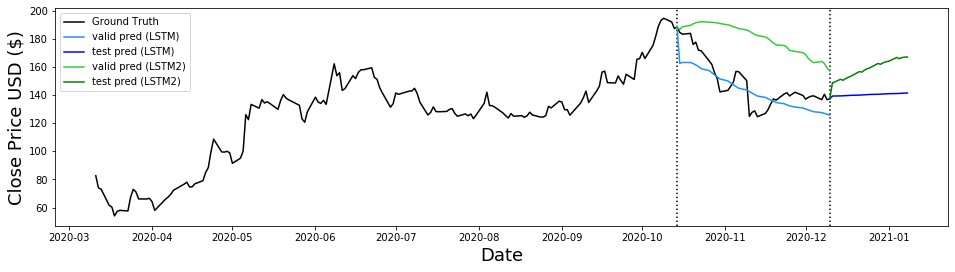

<Figure size 432x288 with 0 Axes>

In [109]:
plt.figure(figsize=(16,4))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

plt.plot(train_final['Date'], reverse_scaler(train_final[y_col], y_col), label='Ground Truth', c='black')
plt.axvline(x=valid_date0-pd.DateOffset(1), ls=':', c='black')
plt.axvline(x=test_date0-pd.DateOffset(1), ls=':', c='black')

plot_with_last_row(last_row=train.loc[len(train)-1], label='valid pred (LSTM)', dates=valid['Date'], pred=valid_pred, y_col=y_col, color='dodgerblue')
plot_with_last_row(last_row=train_final.loc[len(train_final)-1], label='test pred (LSTM)', dates=test['Date'], pred=test_pred, y_col=y_col)

plot_with_last_row(last_row=train.loc[len(train)-1], label='valid pred (LSTM2)', dates=valid['Date'], pred=valid_pred2, y_col=y_col, color='limegreen')
plot_with_last_row(last_row=train_final.loc[len(train_final)-1], label='test pred (LSTM2)', dates=test['Date'], pred=test_pred2, y_col=y_col, color='green')

plt.legend(loc='best')
plt.show()
plt.savefig('./images/stock_results_lstm2.png')

In [105]:
def test_skmodel(clf, x_lag_cols, x_non_lag_cols, y_col, data, with_gt=True):
    predictions = []
    x_valid = np.array(data[x_non_lag_cols + x_lag_cols])

    # for each new prediction, replace the lag data for future x
    for i in range(len(x_valid)):
        pred = clf.predict(np.expand_dims(x_valid[i], 0))[0]
        for j in range(1, max_lag):
            if i + j < x_valid.shape[0]:
                x_valid[i+j][-j] = pred
        predictions.append(reverse_scaler(pred, y_col))
    #print(x_valid)

    # Get the root mean squared error (RMSE)
    rmse = 0
    if with_gt:
        rmse = np.sqrt(np.mean(((predictions - reverse_scaler(np.array(data[y_col]), y_col)) ** 2)))
        print(f'rmse for prediction {y_col} = {rmse:.3f}')
    return predictions, rmse

In [76]:
from sklearn.linear_model import *

In [123]:
rsme_rows = []
x_lag_cols, x_non_lag_cols, y_col = lag_cols[:max_lag][::-1], non_lag_cols, 'Close'
clf_lst = [('Linear Regression', LinearRegression(n_jobs=-1)),
          ('Lasso Regression', Lasso(alpha=0.01)),
           ('SGD Regression', SGDRegressor(max_iter=10000, tol=1e-3)),
           ('Bayesian Ridge',BayesianRidge())]
for name, clf in clf_lst:
    print(name)
    clf.fit(train[x_non_lag_cols + x_lag_cols], train[y_col])
    _, rmse = test_skmodel(clf, x_lag_cols, x_non_lag_cols, y_col, data=valid)
    rsme_rows.append({'model':name, 'rsme':rmse})

Linear Regression
rmse for prediction Close = 87.456
Lasso Regression
rmse for prediction Close = 16.699
SGD Regression
rmse for prediction Close = 43.224
Bayesian Ridge
rmse for prediction Close = 35.777


In [124]:
rsme_rows.append({'model':'LSTM1 (lagged features only)', 'rsme':21.481})
rsme_rows.append({'model':'LSTM2 ', 'rsme':38.436})

rmse for prediction Close = 16.699


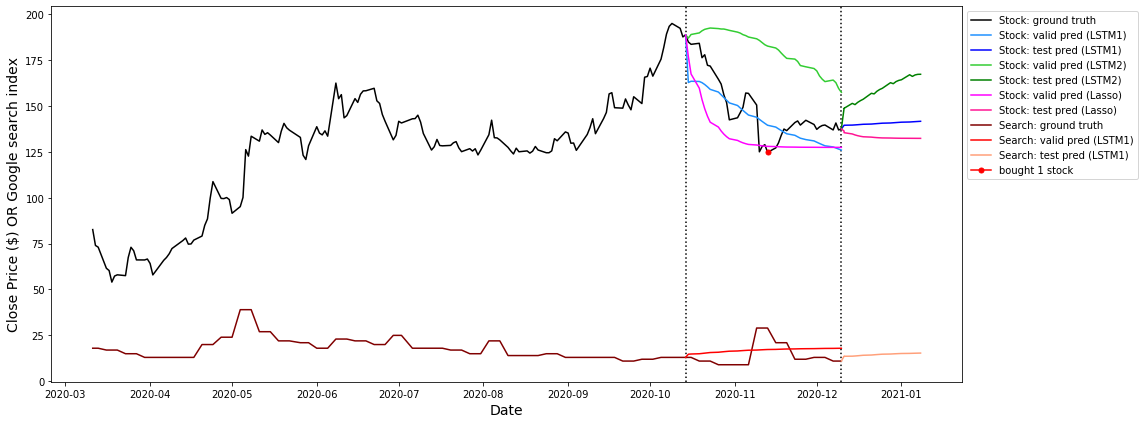

In [112]:
x_lag_cols, x_non_lag_cols, y_col = lag_cols[:max_lag][::-1], non_lag_cols, 'Close'
# clf = LinearRegression(n_jobs=-1)
clf = Lasso(alpha=0.01)
#clf = SGDRegressor(max_iter=10000, tol=1e-3)
#clf = BayesianRidge()

clf.fit(train[x_non_lag_cols + x_lag_cols], train[y_col])
valid_pred3,_ = test_skmodel(clf, x_lag_cols, x_non_lag_cols, y_col, data=valid)

clf.fit(train_final[x_non_lag_cols + x_lag_cols], train_final[y_col])
test_pred3,_ = test_skmodel(clf, x_lag_cols, x_non_lag_cols, y_col, data=test, with_gt=False)

plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price ($) OR Google search index', fontsize=14)

plt.plot(train_final['Date'], reverse_scaler(train_final[y_col], y_col), label='Stock: ground truth', c='black')
plt.axvline(x=valid_date0-pd.DateOffset(1), ls=':', c='black')
plt.axvline(x=test_date0-pd.DateOffset(1), ls=':', c='black')

plot_with_last_row(last_row=train.loc[len(train)-1], label='Stock: valid pred (LSTM1)', dates=valid['Date'], pred=valid_pred, y_col=y_col, color='dodgerblue')
plot_with_last_row(last_row=train_final.loc[len(train_final)-1], label='Stock: test pred (LSTM1)', dates=test['Date'], pred=test_pred, y_col=y_col)

plot_with_last_row(last_row=train.loc[len(train)-1], label='Stock: valid pred (LSTM2)', dates=valid['Date'], pred=valid_pred2, y_col=y_col, color='limegreen')
plot_with_last_row(last_row=train_final.loc[len(train_final)-1], label='Stock: test pred (LSTM2)', dates=test['Date'], pred=test_pred2, y_col=y_col, color='green')

plot_with_last_row(last_row=train.loc[len(train)-1], label='Stock: valid pred (Lasso)', dates=valid['Date'], pred=valid_pred3, y_col=y_col, color='fuchsia')
plot_with_last_row(last_row=train_final.loc[len(train_final)-1], label='Stock: test pred (Lasso)', dates=test['Date'], pred=test_pred3, y_col=y_col, color='deeppink')


plt.plot(train_final['Date'], reverse_scaler(train_final['search'], 'search'), label='Search: ground truth', c='maroon')
plot_with_last_row(last_row=train.loc[len(train)-1], label='Search: valid pred (LSTM1)', dates=valid['Date'], pred=valid_pred_search, y_col='search', color='r')
plot_with_last_row(last_row=train_final.loc[len(train_final)-1], label='Search: test pred (LSTM1)', dates=test['Date'], pred=test_pred_search, y_col='search', color='lightsalmon')

plt.plot([pd.to_datetime('2020-11-13')], [125], marker='o', markersize=5, color="red", label='bought 1 stock')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('./images/stock_results.png')
plt.show()

In [125]:
pd.DataFrame(rsme_rows)

,model,rsme
0,Linear Regression,87.456331
1,Lasso Regression,16.698881
2,SGD Regression,43.224086
3,Bayesian Ridge,35.776756
4,LSTM1 (lagged features only),21.481000
5,LSTM2,38.436000
